In [1]:
import sys
import time
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import h5py

import torch
from torch.utils.data import TensorDataset, DataLoader

/home/pdh/anaconda3/envs/plane/lib/python3.6/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
/home/pdh/anaconda3/envs/plane/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
<KeysViewHDF5 ['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']>
/home/pdh/anaconda3/envs/plane/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low im

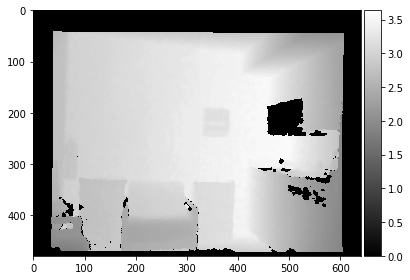

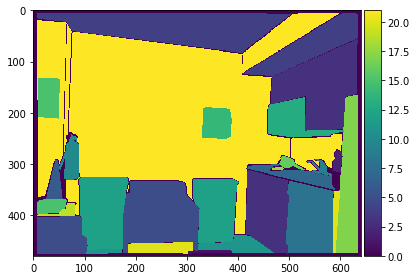

In [2]:
# data path
path_to_depth = '/media/pdh/SSD2/nyu_depth_v2_labeled.mat'

# read mat file
f = h5py.File(path_to_depth)
print(f.keys())

depth, label = next(iter(zip(f['rawDepths'], f['labels'])))
depth = depth.transpose()
label = label.transpose()

io.imshow(depth, cmap=plt.cm.gist_gray)
io.show()
io.imshow(label)
io.show()

In [26]:
print(type(f['labels'][0][0][0]))

msk = generate_mask(f['labels'][0])
print(np.shape(msk))
print(sys.getsizeof(msk))
type(msk[0][0][0])

<class 'numpy.uint16'>
(3, 640, 480)
88


numpy.uint8

In [3]:
def generate_mask(label):
    mask_wall = np.zeros(np.shape(label), dtype = np.float32)
    mask_floor = np.zeros(np.shape(label), dtype = np.float32)
    mask_ceiling = np.zeros(np.shape(label), dtype = np.float32)

    masks = [mask_wall, mask_floor, mask_ceiling]
    index = [21, 11, 4]
    for mask, idx in zip(masks, index):
        idx_arr = np.where(label == idx)
        for x, y in zip(idx_arr[0], idx_arr[1]):
            mask[x,y] = 1

    return masks

def generate_data_array(f):
    sys.stdout.write("start generating \n")
    len_data = len(f['rawDepths'])
    
    sys.stdout.write("generating depth array \n")
    depths_arr = torch.tensor(f['rawDepths'])
    sys.stdout.write("transpose \n")
    depths_arr = depths_arr.transpose(1,2)

    sys.stdout.write("generating mask array \n")
    masks_arr = torch.tensor([generate_mask(f['labels'][i].transpose()) for i in range(0, len_data)])


    return depths_arr, masks_arr

def generate_dataset(darray, marray):
    # darray, marray = generate_data_array(f)
    len_data = len(darray)

    sys.stdout.write("split dataset \n")
    train_size = int(0.8 * len_data)
    val_size = len_data - train_size

    indices = np.random.permutation(len_data)
    training_idx, val_idx = indices[:train_size], indices[train_size:]

    depth_train, depth_val = darray[training_idx,:], darray[val_idx,:]
    mask_train, mask_val = marray[training_idx,:], marray[val_idx,:]

    sys.stdout.write("creating train and val dataset \n")
    trainset = TensorDataset(torch.tensor(depth_train), torch.tensor(mask_train))
    valset = TensorDataset(torch.tensor(depth_val), torch.tensor(mask_val))

    return trainset, valset

In [4]:
darray, narray = generate_data_array(f)
torch.save(darray, './dataset/darray')
del darray
torch.save(narray, './dataset/narray')
del narray
# trainset, valset = generate_dataset(f)

start generating 
generating depth array 
transpose 
generating mask array 


In [6]:
darray = torch.load('./dataset/darray')
marray = torch.load('./dataset/marray')
trainset, valset = generate_dataset(darray, marray)
del darray
del marray

torch.save(trainset, './dataset/train.pt')
del trainset
torch.save(valset, './dataset/val.pt')
del valset

split dataset 
creating train and val dataset 


In [4]:
# da, ma = generate_data_array(f)

# import helper

# dpth_sample = da[0:3,:,:]
# mask_sample = ma[0:3,:,:,:]

# helper.plot_img_array(dpth_sample,3)
# target_masks_rgb = [helper.masks_to_colorimg(x) for x in mask_sample]
# helper.plot_img_array(target_masks_rgb,3)